# 📌 Body Fat Prediction Using XGBoost  

## 🔍 Objective  
This notebook explores a dataset containing body composition measurements and aims to develop an **XGBoost regression model** for predicting body fat percentage. 
The trained model will be integrated into our **SALU: Smart AI Assistant**, allowing users to input their body measurements and receive predictions.  

## 🛠 Workflow  
1. **Exploratory Data Analysis (EDA)** – Understanding distributions, detecting outliers, and feature correlations.  
2. **Feature Engineering & Preprocessing** – Scaling, feature selection, and transformations if needed.  
3. **Model Training & Evaluation** – Training an **XGBoost model**, tuning hyperparameters, and assessing performance.  
4. **Deployment Readiness** – Saving the trained model for integration with the SALU.  >


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,minmax_scale,MinMaxScaler

In [2]:
file_path = "C:/Users/User/sg_health/ML/Data/bodyfat/bodyfat.csv"
df_bodyfat = pd.read_csv(file_path)

# **🔍 Exploratory Data Analysis (EDA) - Quick Data Inspection**
---
## **📌 Function: check_df()**
This function provides a **quick and structured overview** of a given **pandas DataFrame**, helping to understand its basic properties, missing values, and summary statistics.

### **🚀 Function Breakdown**
- **📌 HEAD & TAIL:** Displays the first and last few rows of the dataset.
- **📌 SHAPE:** Prints the number of rows and columns.
- **📌 TYPES:** Shows the data types of all columns.
- **📌 NA (Missing Values):** Counts the number of missing values per column.
- **📌 QUARTILES (Summary Statistics):** Provides percentiles for numerical features.

---


In [3]:
def check_df(dataframe, head=5):
  print(20*"#", "HEAD", 20*"#")
  print(dataframe.head(head))
  print(20*"#", "TAIL", 20*"#")
  print(dataframe.tail(head))
  print(20*"#", "SHAPE", 20*"#")
  print(dataframe.shape)
  print(20*"#", "TYPES", 20*"#")
  print(dataframe.dtypes)
  print(20*"#", "NA", 20*"#")
  print(dataframe.isnull().sum())
  print(20*"#", "QUARTILES", 20*"#")
  print(dataframe.describe([0, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99, 1]).T)

In [4]:
check_df(df_bodyfat)

#################### HEAD ####################
   Density  BodyFat  Age  Weight  Height  Neck  Chest  Abdomen    Hip  Thigh  \
0   1.0708     12.3   23  154.25   67.75  36.2   93.1     85.2   94.5   59.0   
1   1.0853      6.1   22  173.25   72.25  38.5   93.6     83.0   98.7   58.7   
2   1.0414     25.3   22  154.00   66.25  34.0   95.8     87.9   99.2   59.6   
3   1.0751     10.4   26  184.75   72.25  37.4  101.8     86.4  101.2   60.1   
4   1.0340     28.7   24  184.25   71.25  34.4   97.3    100.0  101.9   63.2   

   Knee  Ankle  Biceps  Forearm  Wrist  
0  37.3   21.9    32.0     27.4   17.1  
1  37.3   23.4    30.5     28.9   18.2  
2  38.9   24.0    28.8     25.2   16.6  
3  37.3   22.8    32.4     29.4   18.2  
4  42.2   24.0    32.2     27.7   17.7  
#################### TAIL ####################
     Density  BodyFat  Age  Weight  Height  Neck  Chest  Abdomen    Hip  \
247   1.0736     11.0   70  134.25   67.00  34.9   89.2     83.6   88.8   
248   1.0236     33.6   72  2

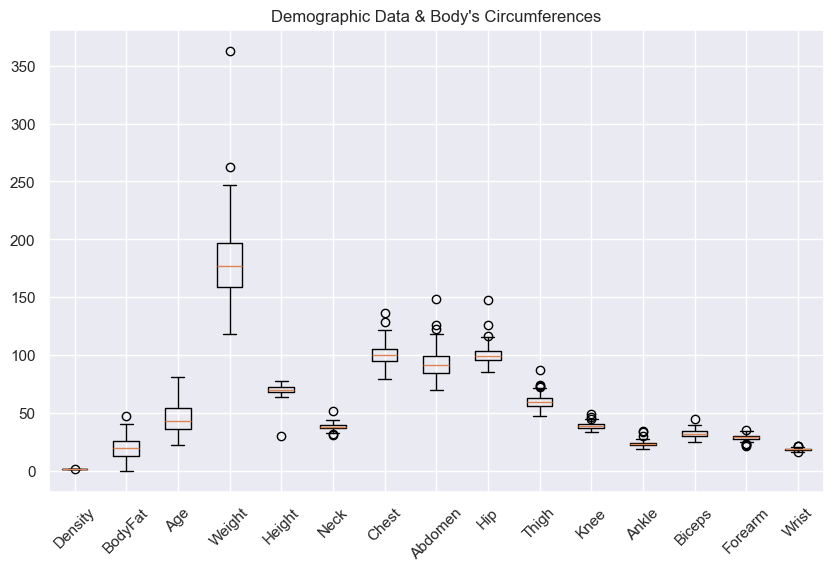

In [22]:
# Define tick labels
body = [i for i in df_bodyfat.columns]

# Create box plot
plt.figure(figsize=(10, 6))  
plt.boxplot(df_bodyfat)
plt.xticks(range(1, len(ticks) + 1), body)  
plt.tick_params(axis='x', rotation=45)
plt.title("Demographic Data & Body's Circumferences")

# Save the plot
plt.savefig("plots_bodyfat/boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

###  Dataset Overview
- **Shape:** `(252, 15)` → 252 rows (samples) and 15 columns (features).
- **Data Types:** All features are numerical (`float64`, `int64`), eliminating the need for categorical encoding.
- **Missing Values:** No null values, ensuring completeness and no immediate need for imputation.
- **Feature Types:**
  - No categorical columns (e.g., gender, categorical groups).
  - All variables are continuous or discrete numeric values.

###  Data Snapshot (First & Last 5 Rows)

- **HEAD:** Displays the first 5 records.
- **TAIL:** Displays the last 5 records.
- **Purpose:** Allows us to quickly validate feature values and check for outliers, incorrect values, or inconsistencies (e.g., negative values in a non-negative feature).

### Descriptive Statistics & Distribution Analysis

### Key Takeaways from `describe()`
The statistical summary reveals valuable insights into the dataset's distribution, spread, and outliers:

#### Central Tendency & Dispersion

- **Mean & Median (50th Percentile):**
  - For most features, the mean and median are close, indicating symmetrical distributions with minimal skewness.
- **Standard Deviation (`std`):**
  - Features such as **Weight, Chest, and Abdomen** have higher variability, suggesting greater spread in body measurements.

#### Min-Max Range & Outliers

- **Potential Outliers (99th percentile vs. max values):**
  - **Weight:** `99th percentile = 245.72`, but `max = 363.15` → **Extreme case.**
  - **Abdomen:** `99th percentile = 120.00`, but `max = 148.10` → **Possible anomaly.**
  - **Chest:** `99th percentile = 120.73`, but `max = 136.20` → **Large upper range deviation.**
- These may indicate outliers or individuals with extreme body compositions, requiring further investigation (e.g., boxplot visualization).

#### Percentile Insights

- **Lower Percentiles (5th, 10th):**
  - Help in understanding the leaner or smaller body types in the dataset.
- **Upper Percentiles (90th, 99th):**
  - Useful for detecting obesity or extreme body proportions.

---


          Density   BodyFat       Age    Weight    Height      Neck     Chest  \
Density  1.000000 -0.987782 -0.277637 -0.594062  0.097881 -0.472966 -0.682599   
BodyFat -0.987782  1.000000  0.291458  0.612414 -0.089495  0.490592  0.702620   
Age     -0.277637  0.291458  1.000000 -0.012746 -0.171645  0.113505  0.176450   
Weight  -0.594062  0.612414 -0.012746  1.000000  0.308279  0.830716  0.894191   
Height   0.097881 -0.089495 -0.171645  0.308279  1.000000  0.253710  0.134892   
Neck    -0.472966  0.490592  0.113505  0.830716  0.253710  1.000000  0.784835   
Chest   -0.682599  0.702620  0.176450  0.894191  0.134892  0.784835  1.000000   
Abdomen -0.798955  0.813432  0.230409  0.887995  0.087813  0.754077  0.915828   
Hip     -0.609331  0.625201 -0.050332  0.940884  0.170394  0.734958  0.829420   
Thigh   -0.553091  0.559608 -0.200096  0.868694  0.148436  0.695697  0.729859   
Knee    -0.495040  0.508665  0.017516  0.853167  0.286053  0.672405  0.719496   
Ankle   -0.264890  0.265970 

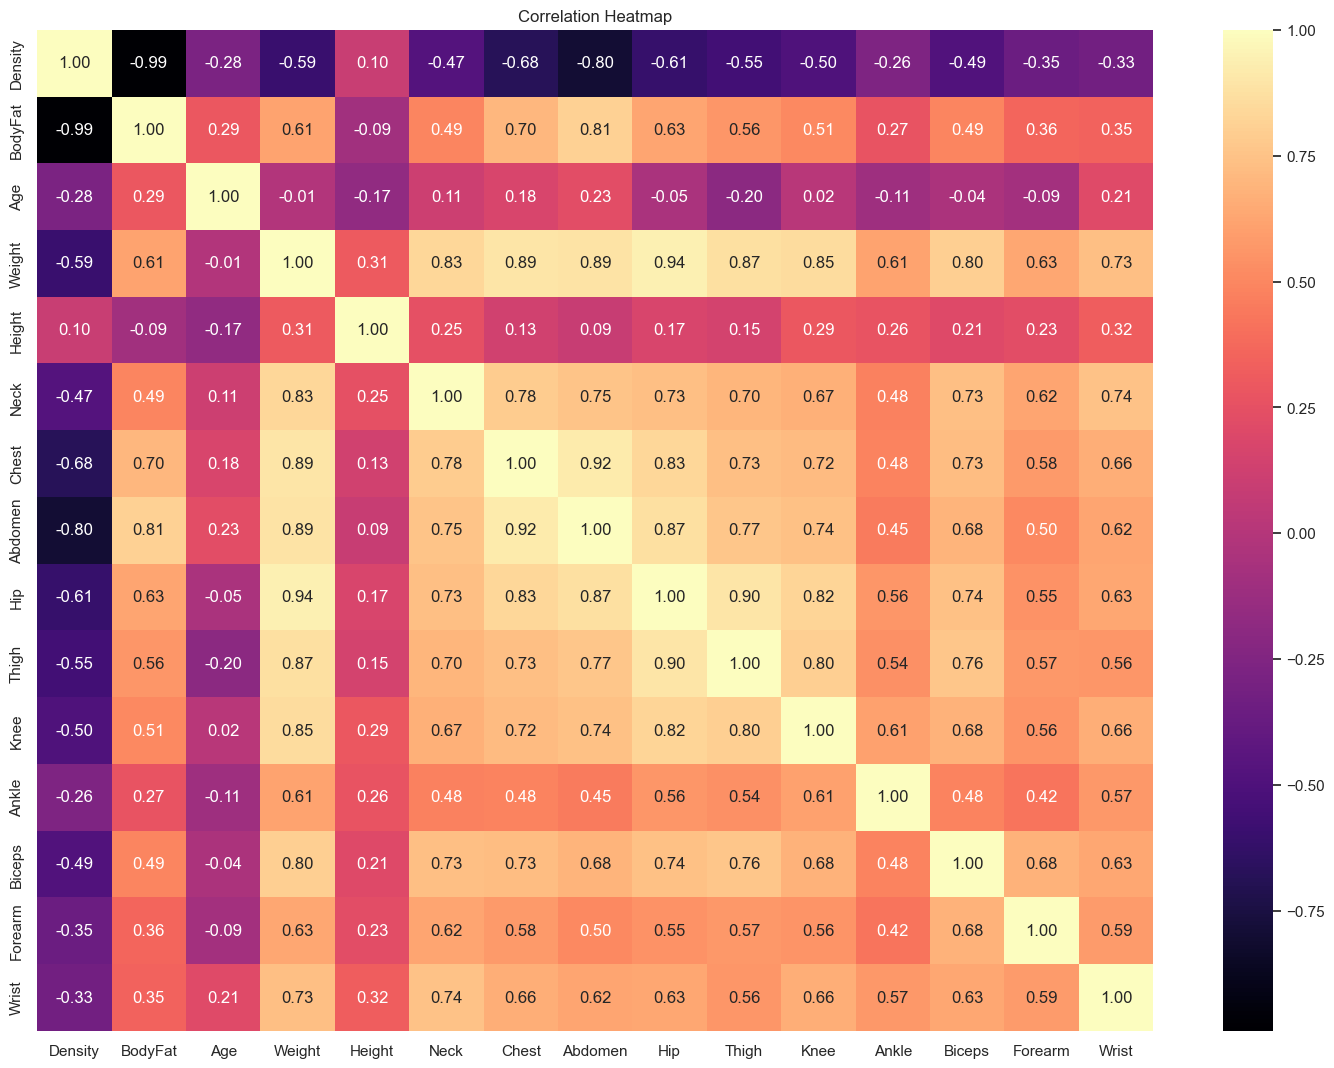

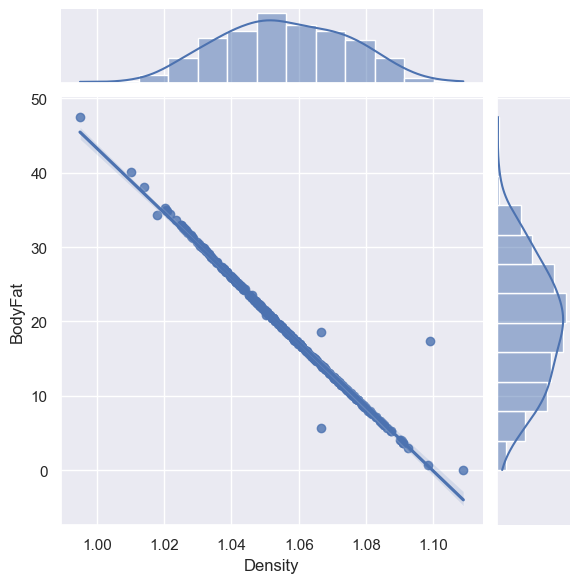

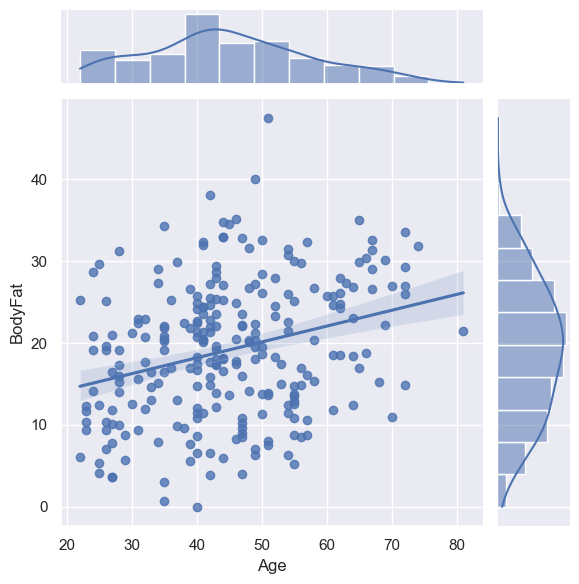

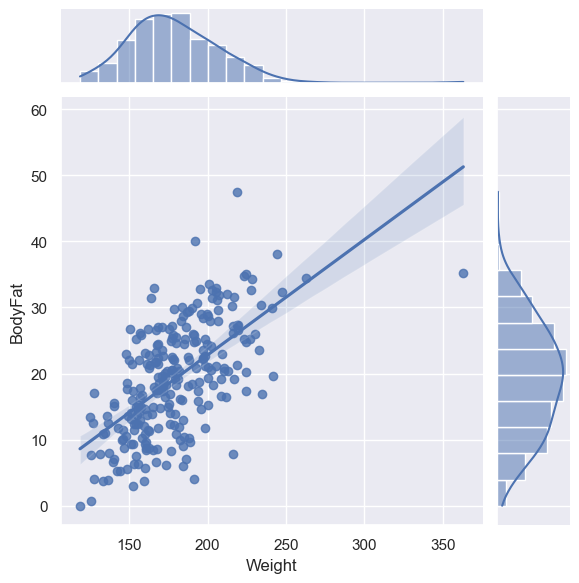

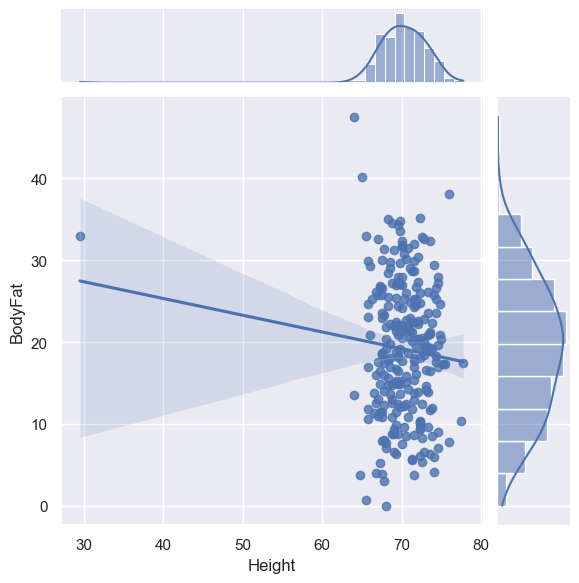

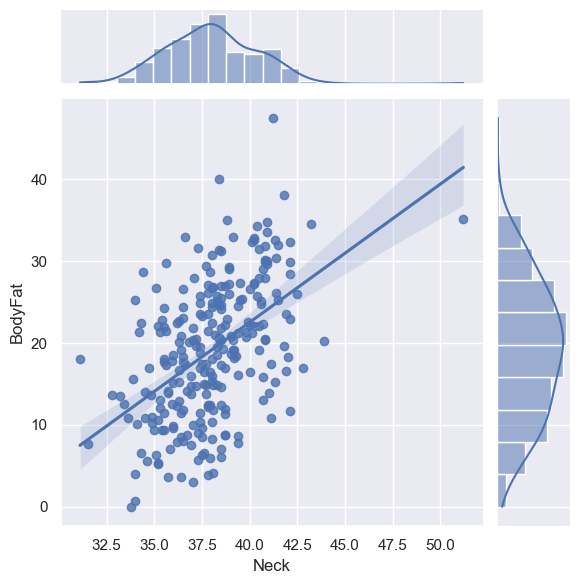

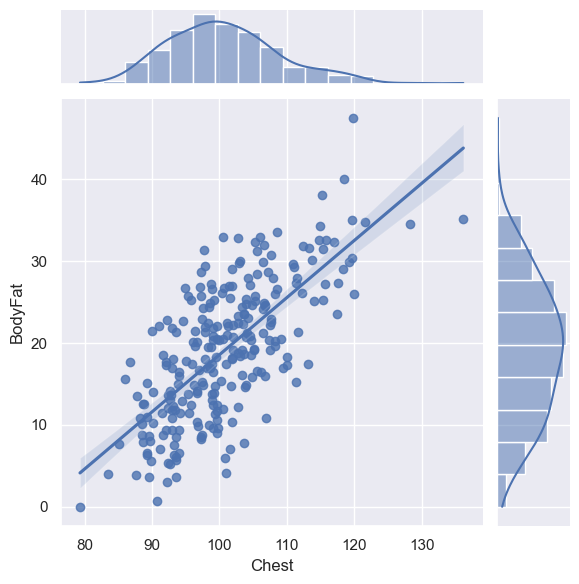

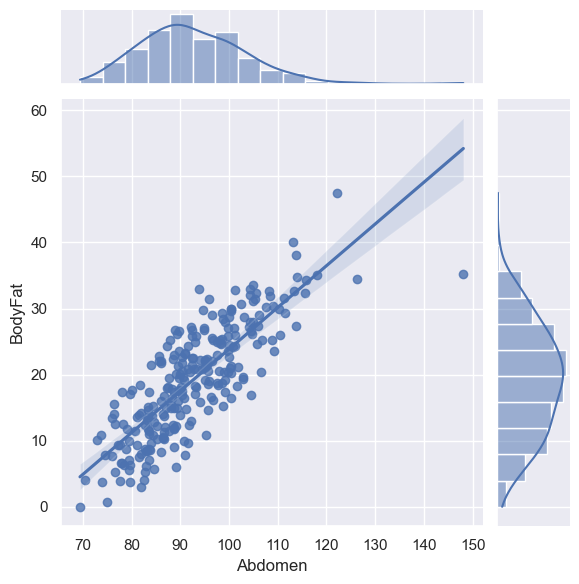

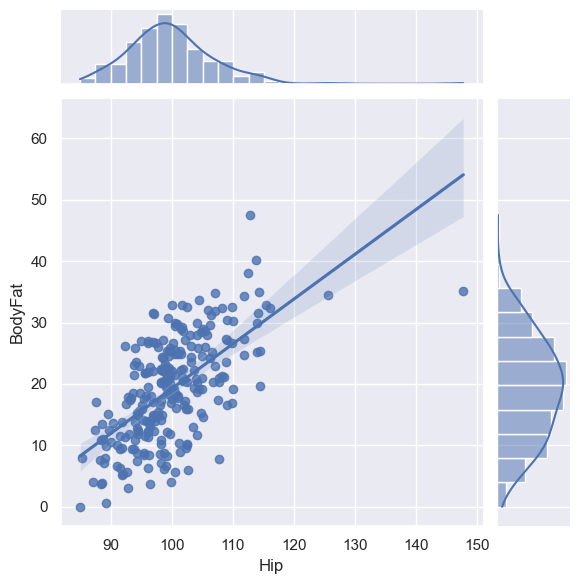

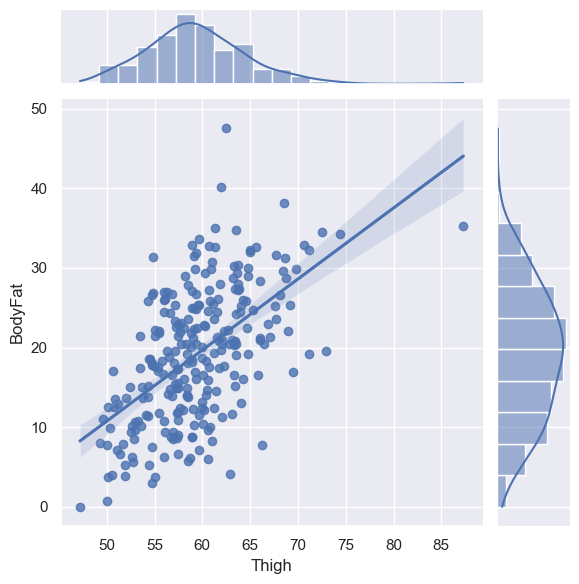

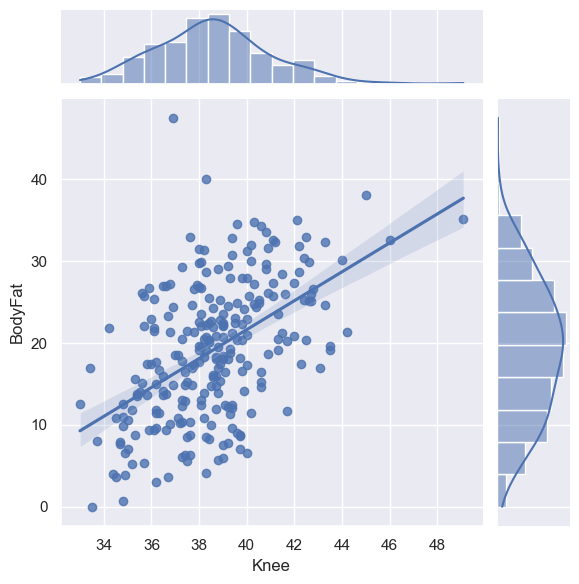

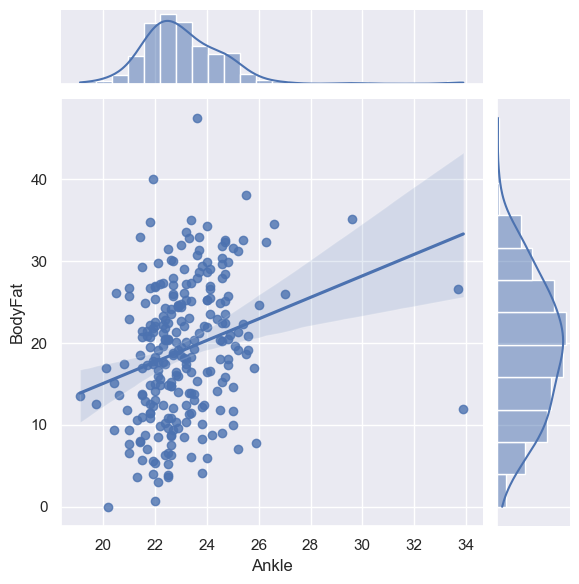

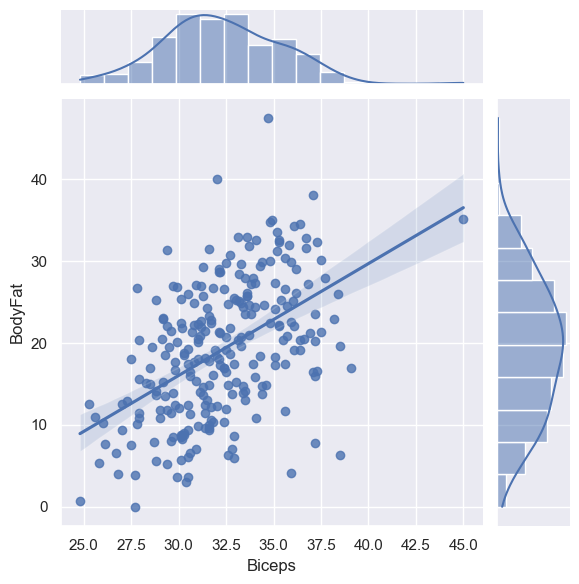

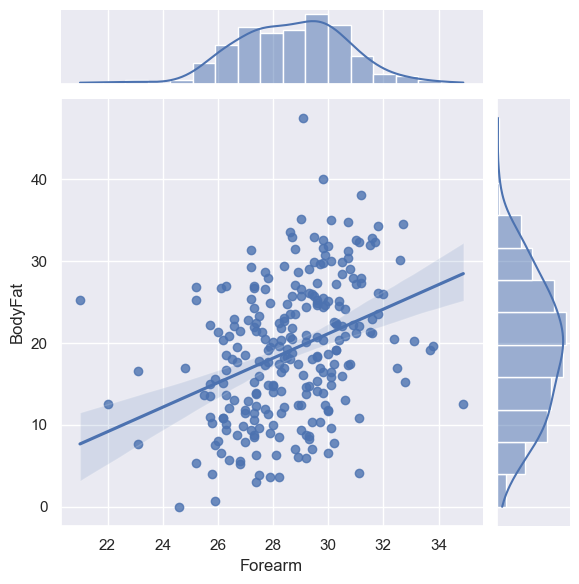

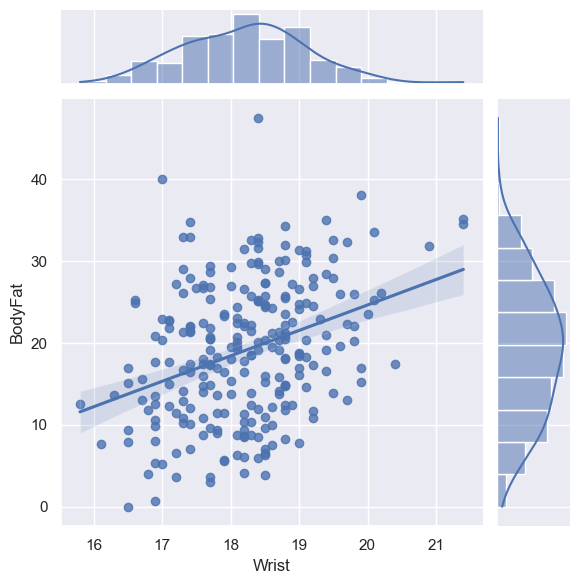

In [9]:
def correlated_cols(dataframe, plot=False, jointplot=False, save_path="plots/"):
    import os
    os.makedirs(save_path, exist_ok=True)  # Create directory if it doesn't exist

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
    corr = dataframe[num_cols].corr()
    print(corr)

    if plot:
        plt.figure(figsize=(18, 13))
        sns.heatmap(corr, cmap='magma', annot=True, fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.savefig(f"{save_path}correlation_heatmap.png", dpi=300, bbox_inches='tight')
        plt.show()

    if jointplot:
        for col in num_cols:
            if col != "BodyFat":  # Avoid plotting BodyFat against itself
                g = sns.jointplot(x=col, y="BodyFat", data=dataframe, kind="reg")
                g.savefig(f"{save_path}jointplot_{col}_vs_BodyFat.png", dpi=300)

# Example usage
correlated_cols(df_bodyfat, plot=True, jointplot=True, save_path="plots_bodyfat/")

The above correlation matrix reveals the relationships between body fat percentage and various body measurements. The key observations are:

1. **Strongest Positive Correlations with Body Fat:**
   - **Abdomen (0.813)**: The strongest predictor of body fat. A larger abdominal circumference strongly correlates with higher body fat.
   - **Chest (0.703)** and **Hip (0.625)**: These measurements also show a strong correlation with body fat, suggesting that fat distribution in these areas is highly relevant.
   - **Weight (0.612)**: Higher body weight is associated with higher body fat but is not the strongest predictor since muscle mass also contributes to weight.
   - **Neck (0.491)** and **Biceps (0.493)**: Moderate correlation, indicating that even upper-body measurements contribute to fat estimation.

2. **Strongest Negative Correlations with Body Fat:**
   - **Density (-0.988)**: As expected, body density has a nearly perfect inverse relationship with body fat. This aligns with Siri’s equation, where density is used to calculate fat percentage.
   - **Height (-0.089)**: Almost negligible correlation, meaning height alone does not predict body fat effectively.

### **Most Influential Predictor:**
- **Abdomen circumference** is the most influential factor (**0.813 correlation**) in predicting body fat. This aligns with medical research showing that central adiposity (fat around the abdomen) is a strong indicator of overall body fat percentage.

### **Conclusion:**
For body fat estimation, abdominal circumference is the most important predictor, followed by chest, hip, and weight. Density remains a theoretical measure rather than a practical input for ML models. 